<a href="https://colab.research.google.com/github/jyryu3161/DrugDiscovery/blob/main/lec10_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 런타임 -> 런타임 유형 변경 -> 고용량 RAM

# Install python packages

In [1]:
!pip install deepchem molvs scikit-learn imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 76.8 MB/s eta 0:00:00
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32374 sha256=0851325890c0d0fb2de1578b8c4e87eb37dcabee44a2e0170bd149859511f9e2
  Stored in directory: /root/.cache/pip/wheels/26/62/a4/147e264c789d9a4e8495f2c3d60f702425761f875bcfdf44e0
Successfully built molvs


# BBBP Prediction Model

### Download dataset

In [2]:
!wget -O bbbp.zip https://www.dropbox.com/scl/fi/6kh2l30lxqh9l5y9kg9uj/bbbp.zip?rlkey=9aksfwk9tuem1jtq4cl4f9cfw&dl=0 # 데이터셋 다운로드
!unzip bbbp.zip # 데이터셋 압축풀기

--2025-05-22 12:06:27--  https://www.dropbox.com/scl/fi/6kh2l30lxqh9l5y9kg9uj/bbbp.zip?rlkey=9aksfwk9tuem1jtq4cl4f9cfw
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uccbee182e7e5319e76b26227024.dl.dropboxusercontent.com/cd/0/inline/CqKbroSM7F8whYFWG__Ydjq4uGOPevY4dGY6dZOf_5Cn-DD8xE8yjbgGL6A2cDGbjh09hRdTPWUlJsUcvzQ5At7A9RnN_pf0b9u1tHNY-FS7j-ktByiGYyAwVqgJhQKdIXgdiT9hsqbxYyMOPSosw651/file# [following]
--2025-05-22 12:06:28--  https://uccbee182e7e5319e76b26227024.dl.dropboxusercontent.com/cd/0/inline/CqKbroSM7F8whYFWG__Ydjq4uGOPevY4dGY6dZOf_5Cn-DD8xE8yjbgGL6A2cDGbjh09hRdTPWUlJsUcvzQ5At7A9RnN_pf0b9u1tHNY-FS7j-ktByiGYyAwVqgJhQKdIXgdiT9hsqbxYyMOPSosw651/file
Resolving uccbee182e7e5319e76b26227024.dl.dropboxusercontent.com (uccbee182e7e5319e76b26227024.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:6

### Preprocessing

In [3]:
import pandas as pd
from rdkit import Chem
from molvs import Standardizer
from molvs.charge import Reionizer
from molvs.tautomer import TautomerCanonicalizer

from rdkit import RDLogger
import time

# RDKit의 로그 레벨을 ERROR로 설정하여 deprecation 경고 숨기기
RDLogger.logger().setLevel(RDLogger.ERROR)

def preprocess_smiles(smiles):
    """
    주어진 SMILES 문자열을 전처리합니다.

    :param smiles: 전처리할 SMILES 문자열
    :return: 전처리된 SMILES 문자열, 유효하지 않은 경우 None
    """
    # RDKit 분자 객체로 변환
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # 유효하지 않은 SMILES

    # MolVS 표준화 적용
    s = Standardizer()
    mol = s.standardize(mol)

    # 재이온화
    reionizer = Reionizer()
    mol = reionizer.reionize(mol)

    # 다시 SMILES로 변환
    return Chem.MolToSmiles(mol)

def preprocess_dataset(input_file, output_file):
    """
    입력 CSV 파일을 읽어 SMILES를 전처리하고 결과를 새 CSV 파일로 저장합니다.

    :param input_file: 입력 CSV 파일 경로
    :param output_file: 출력 CSV 파일 경로
    """
    # CSV 파일 읽기
    df = pd.read_csv(input_file)

    # SMILES 열이 있는지 확인
    if 'smiles' not in df.columns:
        raise ValueError("CSV 파일에 'smiles' 열이 없습니다.")

    # SMILES 전처리
    df['processed_smiles'] = df['smiles'].apply(preprocess_smiles)

    # 유효하지 않은 SMILES 제거
    df = df.dropna(subset=['processed_smiles'])

    # 결과를 새 CSV 파일로 저장
    df.to_csv(output_file, index=False)

# 데이터셋 전처리 실행
datasets = ['train', 'valid', 'test']

for dataset in datasets:
    input_file = f"./bbbp/{dataset}.csv"
    output_file = f"{dataset}_processed.csv"
    print(f"Processing {dataset} dataset...")
    preprocess_dataset(input_file, output_file)
    print(f"{dataset} dataset processing completed.")

print("All datasets have been processed.")

Processing train dataset...


[12:06:29] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:06:29] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:06:30] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:06:30] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:06:30] Explicit valence for atom # 5 N, 4, is greater than permitted
[12:06:32] Can't kekulize mol.  Unkekulized atoms: 12 14


train dataset processing completed.
Processing valid dataset...
valid dataset processing completed.
Processing test dataset...


[12:06:33] Explicit valence for atom # 12 N, 4, is greater than permitted
[12:06:33] Explicit valence for atom # 5 N, 4, is greater than permitted


test dataset processing completed.
All datasets have been processed.


### Generation of molecular features

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit import RDLogger
import time

# RDKit의 로그 레벨을 ERROR로 설정하여 deprecation 경고 숨기기
RDLogger.logger().setLevel(RDLogger.ERROR)

def read_dataset(file_path):
    """
    CSV 파일을 읽어 pandas DataFrame으로 반환합니다.

    :param file_path: CSV 파일 경로
    :return: pandas DataFrame
    """
    df = pd.read_csv(file_path)
    return df

def smiles_to_ecfp4(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # ECFP4 fingerprint 생성 (radius=2)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)

    # bit vector를 numpy array로 변환
    fp_array = np.zeros((nBits,), dtype=int)
    for i in range(nBits):
        fp_array[i] = fp[i]

    return fp_array

def generate_fingerprints(df, smiles_column='processed_smiles', size=2048, radius=2):
    """
    주어진 DataFrame의 SMILES 열을 사용하여 circular fingerprints를 생성합니다.

    :param df: 입력 DataFrame
    :param smiles_column: SMILES 정보가 있는 열 이름
    :param size: fingerprint 길이
    :param radius: 원자 환경을 고려할 반경
    :return: numpy array 형태의 fingerprints
    """
    smiles_list = df[smiles_column].tolist()
    features = []
    for each_smiles in smiles_list:
        feature = smiles_to_ecfp4(each_smiles, radius=radius, nBits=size)
        features.append(feature)
    return np.asarray(features)


def process_dataset(file_path, generate_fp=True):
    """
    주어진 파일 경로의 데이터셋을 처리하여 fingerprints를 생성합니다.

    :param file_path: 처리할 CSV 파일 경로
    :param generate_fp: fingerprints 생성 여부
    :return: 생성된 특성들을 포함하는 딕셔너리와 타겟 값
    """
    df = read_dataset(file_path)
    y = df['p_np'].values  # 타겟 값 추출

    results = {}
    if generate_fp:
        fingerprints = generate_fingerprints(df)
        results['fingerprints'] = fingerprints

    return results, y

# 데이터셋 처리 및 특성 생성
train_results, train_y = process_dataset('train_processed.csv')
valid_results, valid_y = process_dataset('valid_processed.csv')
test_results, test_y = process_dataset('test_processed.csv')

# 생성된 특성의 형태 출력
print("Train fingerprints shape:", train_results['fingerprints'].shape)
print("Valid fingerprints shape:", valid_results['fingerprints'].shape)
print("Test fingerprints shape:", test_results['fingerprints'].shape)

# 생성된 특성과 타겟 값을 numpy 파일로 저장
np.save('./train_X.npy', train_results['fingerprints'])
np.save('./valid_X.npy', valid_results['fingerprints'])
np.save('./test_X.npy', test_results['fingerprints'])
np.save('./train_y.npy', train_y)
np.save('./valid_y.npy', valid_y)
np.save('./test_y.npy', test_y)

print("All data has been processed and saved.")

Train fingerprints shape: (1634, 2048)
Valid fingerprints shape: (205, 2048)
Test fingerprints shape: (192, 2048)
All data has been processed and saved.


### Data distribution

In [5]:
print(len(train_y[train_y==1])) # BBB Permeable
print(len(train_y[train_y==0])) # BBB Non-permeable

1286
348


### Model training

In [6]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import os
import joblib


def load_data(prefix):
    """
    지정된 접두사를 가진 numpy 파일에서 특성(X)과 레이블(y)을 로드합니다.
    """
    X = np.load(f"{prefix}_X.npy")
    y = np.load(f"{prefix}_y.npy")
    return X, y

def evaluate_model(model, X, y):
    """
    주어진 모델을 평가하고 여러 성능 지표를 반환합니다.
    """
    # 예측 수행
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]  # 양성 클래스 확률

    # 성능 지표 계산
    metrics = {
        "ACC": accuracy_score(y, y_pred),
        "AUROC": roc_auc_score(y, y_pred_proba),
        "MCC": matthews_corrcoef(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": recall_score(y, y_pred, zero_division=0)
    }

    return metrics

def train_and_evaluate(X_train, y_train, X_valid, y_valid, X_test, y_test, sampling_method=None):
    # 샘플링 방법 적용 (지정된 경우)
    if sampling_method:
        if sampling_method == "under":
            sampler = RandomUnderSampler(random_state=42)
        elif sampling_method == "over":
            sampler = RandomOverSampler(random_state=42)
        elif sampling_method == "smote":
            sampler = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    # RandomForest 모델 생성 및 학습
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train_resampled, y_train_resampled)
    model_path = save_model(model, sampling_method)

    # 각 데이터셋에 대해 모델 평가
    train_metrics = evaluate_model(model, X_train, y_train)
    valid_metrics = evaluate_model(model, X_valid, y_valid)
    test_metrics = evaluate_model(model, X_test, y_test)

    return {
        "train": train_metrics,
        "valid": valid_metrics,
        "test": test_metrics
    }

def save_model(model, sampling_method, model_dir="saved_models"):
    """
    훈련된 모델을 저장합니다.
    """
    # 모델 저장 디렉토리 생성
    os.makedirs(model_dir, exist_ok=True)

    # 파일명 생성
    model_name = f"random_forest_{sampling_method if sampling_method else 'original'}.pkl"
    model_path = os.path.join(model_dir, model_name)

    # 모델 저장
    joblib.dump(model, model_path)
    print(f"Model saved: {model_path}")

    return model_path

def load_saved_model(model_path):
    """
    저장된 모델을 로드합니다.
    """
    return joblib.load(model_path)

# 데이터 로드
X_train, y_train = load_data("train")
X_valid, y_valid = load_data("valid")
X_test, y_test = load_data("test")

# 샘플링 방법 설정
sampling_methods = [None, "under", "over", "smote"]
results = {}

# 각 샘플링 방법에 대해 학습 및 평가 수행
for sampling in sampling_methods:
    key = f"random_forest_{sampling if sampling else 'original'}"
    print(f"Training {key}...")
    results[key] = train_and_evaluate(X_train, y_train, X_valid, y_valid, X_test, y_test, sampling)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame.from_dict({(i,j): results[i][j]
                                        for i in results.keys()
                                        for j in results[i].keys()},
                                    orient='index')

# 결과를 CSV 파일로 저장
df_results.to_csv('rf_evaluation_results.csv')
print("Results saved to 'rf_evaluation_results.csv'")

# 결과 출력
print("\n=== Random Forest 결과 ===")
print(df_results)



Training random_forest_original...
Model saved: saved_models/random_forest_original.pkl
Training random_forest_under...
Model saved: saved_models/random_forest_under.pkl
Training random_forest_over...
Model saved: saved_models/random_forest_over.pkl
Training random_forest_smote...
Model saved: saved_models/random_forest_smote.pkl
Results saved to 'rf_evaluation_results.csv'

=== Random Forest 결과 ===
                                   ACC     AUROC       MCC  Precision  \
random_forest_original train  0.993880  0.999876  0.981712   0.995342   
                       valid  0.873171  0.946437  0.682861   0.865031   
                       test   0.859375  0.935890  0.709205   0.818792   
random_forest_under    train  0.924725  0.991602  0.815713   0.998286   
                       valid  0.873171  0.929425  0.712454   0.940741   
                       test   0.869792  0.924941  0.721916   0.907563   
random_forest_over     train  0.993268  0.999771  0.980144   0.998436   
             

# Machine learning based binding affinity prediction

In [7]:
!wget -O enamine_lib.smiles https://www.dropbox.com/scl/fi/7s40vsgavxtiy4fqk3dgi/Enamine_Hit_Locator_Library_plated_460160cmpds_20250511.smiles?rlkey=d1ixit28b8qgd9pc1p1usohuh&st=je40l477&dl=0 # 데이터셋 다운로드


--2025-05-22 12:06:43--  https://www.dropbox.com/scl/fi/7s40vsgavxtiy4fqk3dgi/Enamine_Hit_Locator_Library_plated_460160cmpds_20250511.smiles?rlkey=d1ixit28b8qgd9pc1p1usohuh
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc90a472ad248ec8a5c0732e72e2.dl.dropboxusercontent.com/cd/0/inline/CqJNy91QnQLVhGT46BXoxoAVKctZKEDmoFMGKVoyvYsp4v4eRMgFyH8V3NFXB_GG_AXm2a3s6ZVolY6JiWlOgAzKFhpHcw1P_zgWyBnAORz7KwcyAleJX4eKIEys_PSEB9sjeUIXyEKKEc7JHNjEl8Yi/file# [following]
--2025-05-22 12:06:44--  https://uc90a472ad248ec8a5c0732e72e2.dl.dropboxusercontent.com/cd/0/inline/CqJNy91QnQLVhGT46BXoxoAVKctZKEDmoFMGKVoyvYsp4v4eRMgFyH8V3NFXB_GG_AXm2a3s6ZVolY6JiWlOgAzKFhpHcw1P_zgWyBnAORz7KwcyAleJX4eKIEys_PSEB9sjeUIXyEKKEc7JHNjEl8Yi/file
Resolving uc90a472ad248ec8a5c0732e72e2.dl.dropboxusercontent.com (uc90a472ad248ec8a5c0732e72e2.

In [10]:
import pandas as pd

docking_result_df = pd.read_csv('./docking_results.csv', sep=',')
print(docking_result_df.head())

df = pd.read_csv('./enamine_lib.smiles', sep='\t')
print(df.head())

    Catalog ID                                             SMILES  \
0   Z966268928  O=C(NC=1C=CC=C(C1)C(=O)N2CCC=3C=CC=CC32)C4=CC=...   
1  Z8427073885  O=C(NC=1C=C(C=CC1F)C=2C=CC=CC2)C3=NN4C(=N3)NC(...   
2   Z767239376  CC1(NC(=O)NC1=O)C=2C=CC(=CC2)NC(=O)C=3C=C(N=C4...   
3  Z1451728458  CC1(NC(=O)NC1=O)C=2C=CC=C(C2)C(=O)NC=3C=CC=4NC...   
4  Z5164709323  O=C(NC=1C=CC=C(C1)C=2C=CN=CC2)C=3C=CC4=C(C3)CC...   

   Vina Affinity (kcal/mol)  Pose                        Output File  
0                     -10.5    10   docking_pose_Z966268928_10.pdbqt  
1                     -10.1     4   docking_pose_Z8427073885_4.pdbqt  
2                     -10.0     1    docking_pose_Z767239376_1.pdbqt  
3                      -9.8     1   docking_pose_Z1451728458_1.pdbqt  
4                      -9.8    10  docking_pose_Z5164709323_10.pdbqt  
                                           SMILES   Catalog ID       MW  \
0        CC(OC=1C=CC=C(C#N)C1)C(=O)N2CCCCC2C(=O)O  Z1251193392  302.326   
1      CC

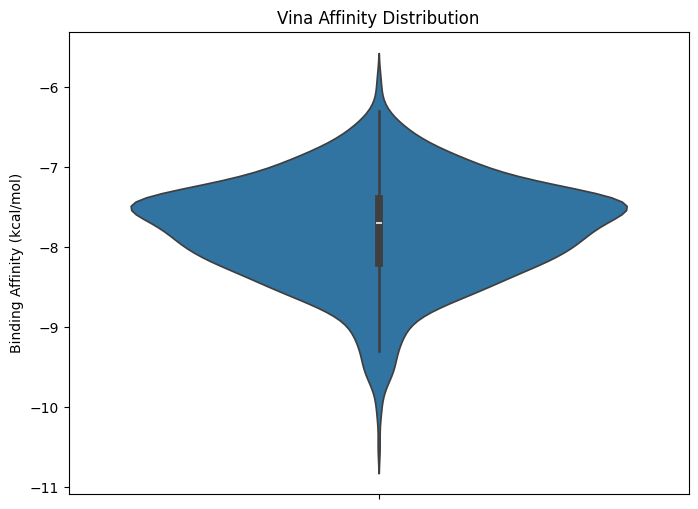

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
docking_result_df = pd.read_csv('./docking_results.csv', sep=',')

# Violin plot 그리기
plt.figure(figsize=(8, 6))
sns.violinplot(y=docking_result_df['Vina Affinity (kcal/mol)'])
plt.title('Vina Affinity Distribution')
plt.ylabel('Binding Affinity (kcal/mol)')
plt.show()

In [13]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
import tqdm
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def smiles_to_ecfp4(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # ECFP4 fingerprint 생성 (radius=2)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)

    # bit vector를 numpy array로 변환
    fp_array = np.zeros((nBits,), dtype=int)
    for i in range(nBits):
        fp_array[i] = fp[i]

    return fp_array

def prepare_ecfp4_features(df, smiles_column='SMILES', radius=2, nBits=2048):
    print(f"Calculating ECFP4 fingerprints for {len(df)} molecules...")
    print(f"Parameters: radius={radius}, nBits={nBits}")

    features_list = []
    valid_indices = []

    for idx, smiles in tqdm.tqdm(enumerate(df[smiles_column]), total=len(df), desc="Processing molecules"):
        if pd.isna(smiles):
            continue

        fp_array = smiles_to_ecfp4(smiles, radius=radius, nBits=nBits)
        if fp_array is not None:
            features_list.append(fp_array)
            valid_indices.append(idx)

    if len(features_list) == 0:
        return None, []

    # numpy array로 변환
    features_matrix = np.array(features_list)

    print(f"Successfully generated fingerprints for {len(features_matrix)} molecules")
    print(f"Fingerprint shape: {features_matrix.shape}")

    return features_matrix, valid_indices



# 기존 코드
docking_result_df = pd.read_csv('./docking_results.csv', sep=',')
docking_result_df['Vina Affinity Transform'] = docking_result_df['Vina Affinity (kcal/mol)']*-1.0/15.0

# 1. 학습 데이터 준비 (ECFP4 사용)
print("\n=== Preparing Training Data with ECFP4 ===")
# SMILES에서 ECFP4 fingerprint 추출
train_features, train_valid_indices = prepare_ecfp4_features(docking_result_df, 'SMILES', radius=2, nBits=2048)

# 유효한 인덱스에 해당하는 타겟 값 추출
train_target = docking_result_df.loc[train_valid_indices, 'Vina Affinity Transform'].values

print(f"Training features shape: {train_features.shape}")
print(f"Target values shape: {train_target.shape}")
print(f"Target statistics - Min: {train_target.min():.3f}, Max: {train_target.max():.3f}, Mean: {train_target.mean():.3f}")

# ECFP4 fingerprint 통계
print(f"Fingerprint density: {(train_features.sum() / train_features.size * 100):.2f}% (non-zero bits)")

# 2. 모델 학습
print("\n=== Training Random Forest Model with ECFP4 ===")
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    train_features, train_target, test_size=0.2, random_state=42
)

# Random Forest 회귀 모델 생성 및 학습
rf_model = RandomForestRegressor()

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# 3. 모델 평가
print("\n=== Model Evaluation ===")
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)

print("Training Set:")
print(f"  R² Score: {r2_score(y_train, train_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")

print("Test Set:")
print(f"  R² Score: {r2_score(y_test, test_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")

# 4. 새로운 데이터에 예측 적용
print("\n=== Predicting on New Data with ECFP4 ===")

df = pd.read_csv('./enamine_lib.smiles', sep='\t')
print("Enamine Library Data:")
print(df.head())

# 새로운 데이터에서 ECFP4 fingerprint 추출
pred_features, pred_valid_indices = prepare_ecfp4_features(df, 'SMILES', radius=2, nBits=2048)

# 예측 수행
print("Making predictions...")
predictions = rf_model.predict(pred_features)

# 결과를 원본 DataFrame에 추가
df['predicted_affinity'] = np.nan
df.loc[pred_valid_indices, 'predicted_affinity'] = predictions

print(f"Predictions completed for {len(pred_valid_indices)} molecules out of {len(df)}")
print(f"Predicted affinity statistics:")
print(f"  Min: {predictions.min():.3f}")
print(f"  Max: {predictions.max():.3f}")
print(f"  Mean: {predictions.mean():.3f}")
print(f"  Std: {predictions.std():.3f}")

# 5. 상위 1000개 화합물 선별 (affinity가 낮을수록 좋음)
print("\n=== Selecting Top 1000 Compounds ===")
# NaN 값 제외하고 정렬
df_valid = df.dropna(subset=['predicted_affinity'])
top_1000 = df_valid.nsmallest(1000, 'predicted_affinity')

# 결과 저장
top_1000.to_csv('lib_ml_selected.csv', index=False)
df.to_csv('lib_ml_all.csv', index=False)



=== Preparing Training Data with ECFP4 ===
Calculating ECFP4 fingerprints for 992 molecules...
Parameters: radius=2, nBits=2048


Processing molecules: 100%|██████████| 992/992 [00:01<00:00, 932.29it/s]


Successfully generated fingerprints for 992 molecules
Fingerprint shape: (992, 2048)
Training features shape: (992, 2048)
Target values shape: (992,)
Target statistics - Min: 0.393, Max: 0.700, Mean: 0.519
Fingerprint density: 2.31% (non-zero bits)

=== Training Random Forest Model with ECFP4 ===
Training Random Forest model...

=== Model Evaluation ===
Training Set:
  R² Score: 0.9284
  RMSE: 0.0116
Test Set:
  R² Score: 0.4511
  RMSE: 0.0295

=== Predicting on New Data with ECFP4 ===
Enamine Library Data:
                                           SMILES   Catalog ID       MW  \
0        CC(OC=1C=CC=C(C#N)C1)C(=O)N2CCCCC2C(=O)O  Z1251193392  302.326   
1      CCC(=O)NC1=CC=C(F)C(=C1)S(=O)(=O)NC(C)(C)C  Z1251673928  302.367   
2        O=C(CN1C=CC=N1)NC2=NC=3C=CC=CC3N2C4CCCC4  Z1251687843  309.367   
3    O=C1OCCN1C=2C=CC(=CC2)S(=O)(=O)NC=3C=CC=CC3F  Z1251701673  336.340   
4  O=S(=O)(CC1CCCCO1)NC=2C=CC=CC2C3=NN=C4CCCCCN34  Z1251703037  390.502   

   MW (desalted)  ClogP   logS  HBD 

Processing molecules: 100%|██████████| 460160/460160 [08:00<00:00, 957.86it/s]


Successfully generated fingerprints for 460160 molecules
Fingerprint shape: (460160, 2048)
Making predictions...
Predictions completed for 460160 molecules out of 460160
Predicted affinity statistics:
  Min: 0.451
  Max: 0.614
  Mean: 0.510
  Std: 0.017

=== Selecting Top 1000 Compounds ===


In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import os
import joblib
warnings.filterwarnings('ignore')

def smiles_to_ecfp4(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # ECFP4 fingerprint 생성 (radius=2)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)

    # bit vector를 numpy array로 변환
    fp_array = np.zeros((nBits,), dtype=int)
    for i in range(nBits):
        fp_array[i] = fp[i]

    return fp_array

def load_saved_model(model_path):
    """
    저장된 모델을 로드합니다.
    """
    return joblib.load(model_path)

df = pd.read_csv("lib_ml_selected.csv")
features = []
for each_smiles in df['SMILES']:
    feature = smiles_to_ecfp4(each_smiles, radius=2, nBits=2048)
    features.append(feature)

model_path = './saved_models/random_forest_smote.pkl'
rf_model = load_saved_model(model_path)

results = rf_model.predict_proba(features)
print(results)

df['BBBP_probability'] = results[:, 1]  # permeable 확률 (1 클래스)
df['BBBP'] = (results[:, 1] > 0.5).astype(int)

output_filename = "lib_ml_selected_with_bbbp_predictions.csv"
df.to_csv(output_filename, index=False)

print("\n=== 예측 결과 샘플 ===")
print(df[['SMILES', 'BBBP_probability', 'BBBP']].head(10))

[[0.35   0.65  ]
 [0.26   0.74  ]
 [0.38   0.62  ]
 ...
 [0.2625 0.7375]
 [0.26   0.74  ]
 [0.23   0.77  ]]

=== 예측 결과 샘플 ===
                                        SMILES  BBBP_probability  BBBP
0           O=C(NCC1(CCOCC1)OCCO)C(C2CC2)C3CC3          0.650000     1
1       Cl.CCCC(N)C(=O)N(C)CC=1C=CC=C(C1)N(C)C          0.740000     1
2          CCCNC(=O)NC=1C=CC=C(C1)COCC2=CC=CO2          0.620000     1
3    CC(C)[C@@H](C#N)NS(=O)(=O)C=1C=CC(=CC1)CF          0.460000     0
4  CC(C)C1(O)CN(C1)C(=O)C2=CC=C(C=N2)C=3C=NNC3          0.580000     1
5                  CCC(C)C(=O)NCC1(CCOCC1)OCCO          0.700000     1
6      CCCC(N)C(=O)NCC=1C=CC=C(C1)NC(=O)C(C)CC          0.706667     1
7            CCOCC=1C=CC=C(C1)NC(=O)NC=2C=NNC2          0.680000     1
8       CC1(C)C(CNC(=O)NCC2(CCOCC2)OCCO)C1(C)C          0.610000     1
9              CCOCC=1C=CC=C(C1)NC(=O)C2COCCO2          0.720000     1
